In [1]:

from contextlib import redirect_stdout

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from tensorflow import keras as keras
from sklearn.metrics import RocCurveDisplay

from drowsiness_detection import config
from drowsiness_detection.data import label_names_dict
from drowsiness_detection.data import load_experiment_data
from drowsiness_detection.models import ThreeDStandardScaler

In [2]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def save_summary(model, X_test, y_test):
    y_hat = model.predict(X_test)
    if not y_hat.shape[-1] == 1:
        y_hat = np.argmax(y_hat, axis=1)
    else:
        y_hat = (y_hat > .5)
    acc = np.mean(y_hat == y_test)

    print("mean-prediction", np.mean(y_hat))
    with open("summaries.csv", "a") as fp:
        fp.write(str(round(acc, 4)) + "\n")
        with redirect_stdout(fp):
            model.summary()
        fp.write("\n")

    report = classification_report(y_true=y_test, y_pred=y_hat,
                                   target_names=label_names_dict[2])
    print(report)


In [3]:
# load data
config.set_paths(30, 60)
X_train, X_test, y_train, y_test, cv_splits = load_experiment_data(
    exclude_by="a",
    num_targets=2,
    seed=45,
    test_size=.2,
    split_by_subjects=True,
    use_dummy_data=False,
    nn_experiment=True,
    feature_col_indices=(5, 8, 9, 14, 15, 16, 19),
    model_name="mvts_transformer")

X_train shape: (26642, 1800, 7), y_train shape: (26642,)
X_test shape: (6494, 1800, 7), y_test shape: (6494,)


In [4]:
num_samples = None
X_train = X_train[:num_samples]
X_test = X_test[:num_samples]
y_test = y_test[:num_samples]
y_train = y_train[:num_samples]



In [5]:
scaler = ThreeDStandardScaler(feature_axis=-1)

X_train_scaled = scaler.fit_transform(X_train, y_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# input_shape = (100, 1800, 7)
#
# num_filters = 64, 16, 4
# kernel_sizes = 5, 3, 3
# strides = 3, 1, 1
#
# input_layer = keras.layers.Input(input_shape[1:])
# conv_layer1 = keras.layers.Conv1D(filters=num_filters[0], kernel_size=kernel_sizes[0],
#                                   strides=strides[0],
#                                   padding="same")(input_layer)
# conv_layer1 = keras.layers.BatchNormalization()(conv_layer1)
# conv_layer1 = keras.layers.ReLU()(conv_layer1)
#
# conv_layer2 = keras.layers.Conv1D(filters=num_filters[1], kernel_size=kernel_sizes[1],
#                                   strides=strides[1],
#                                   padding="same")(conv_layer1)
# conv_layer2 = keras.layers.BatchNormalization()(conv_layer2)
# conv_layer2 = keras.layers.ReLU()(conv_layer2)
#
# conv_layer3 = keras.layers.Conv1D(filters=num_filters[2], kernel_size=kernel_sizes[2],
#                                   strides=strides[2],
#                                   padding="same")(conv_layer2)
# conv_layer3 = keras.layers.BatchNormalization()(conv_layer3)
# conv_layer3 = keras.layers.ReLU()(conv_layer3)
#
# pool_layer = keras.layers.GlobalMaxPool1D()(conv_layer3)
# # pool_layer = keras.layers.GlobalAvgPool1D()(conv_layer3)
#
# dense_layer = keras.layers.Dense(64, activation='relu')(pool_layer)
# dropout_layer = keras.layers.Dropout(0.8)(dense_layer)
# output_layer = keras.layers.Dense(1, activation="sigmoid")(dropout_layer)
#
# model = keras.models.Model(inputs=input_layer, outputs=output_layer)
#
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# print(model.summary())
#


In [7]:
def build_cnn_model1(input_shape,
                    kernel_size=5,
                    stride=1,
                    num_filters=32,
                    num_conv_layers=2,
                    padding="same",
                    use_batch_norm=True,
                    pooling="average",
                    dropout_rate=.2, learning_rate=.002):
    input_layer = keras.layers.Input(input_shape[1:])
    prev_layer = input_layer
    for _ in range(num_conv_layers):
        conv_layer = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size,
                                         strides=stride,
                                         padding=padding)(prev_layer)
        if use_batch_norm:
            conv_layer = keras.layers.BatchNormalization()(conv_layer)
        conv_layer = keras.layers.ReLU()(conv_layer)
        prev_layer = conv_layer

    if pooling == "average":
        pool_layer = keras.layers.GlobalAveragePooling1D()(prev_layer)
    elif pooling == "max":
        pool_layer = keras.layers.GlobalMaxPool1D()(prev_layer)
    else:
        pool_layer = prev_layer

    dense_layer = keras.layers.Dense(32, activation='relu')(pool_layer)
    dropout_layer = keras.layers.Dropout(dropout_rate)(dense_layer)
    output_layer = keras.layers.Dense(1, activation="sigmoid")(dropout_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    print(model.summary())
    return model


In [8]:
input_shape = (100, 1800, 7)

model1 = build_cnn_model1(input_shape=input_shape,
                        dropout_rate=0.725,
                        kernel_size=5,
                        num_conv_layers=2,
                        num_filters=44,
                        pooling="max",
                        stride=3,
                        learning_rate=0.009)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1800, 7)]         0         
                                                                 
 conv1d (Conv1D)             (None, 600, 44)           1584      
                                                                 
 batch_normalization (BatchN  (None, 600, 44)          176       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 600, 44)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 200, 44)           9724      
                                                                 
 batch_normalization_1 (Batc  (None, 200, 44)          176       
 hNormalization)                                             

In [9]:
history1 = model1.fit(
    x=X_train_scaled,
    y=y_train,
    epochs=30,
    class_weight={0: 0.84, 1: 1.14},
    batch_size=16,
    validation_data=(X_test_scaled, y_test),
    # use_multiprocessing=False,
    # workers=7

)

Epoch 1/30
1666/1666 [==============================] - 18s 10ms/step - loss: 0.6594 - accuracy: 0.5636 - val_loss: 0.6784 - val_accuracy: 0.5450
Epoch 2/30
1666/1666 [==============================] - 17s 10ms/step - loss: 0.6464 - accuracy: 0.5342 - val_loss: 0.6733 - val_accuracy: 0.5594
Epoch 3/30
1666/1666 [==============================] - 17s 10ms/step - loss: 0.6335 - accuracy: 0.5350 - val_loss: 0.6868 - val_accuracy: 0.5222
Epoch 4/30
1666/1666 [==============================] - 17s 10ms/step - loss: 0.6134 - accuracy: 0.5737 - val_loss: 0.7201 - val_accuracy: 0.5482
Epoch 5/30
1666/1666 [==============================] - 17s 10ms/step - loss: 0.5757 - accuracy: 0.6325 - val_loss: 0.6854 - val_accuracy: 0.5681
Epoch 6/30
1666/1666 [==============================] - 17s 10ms/step - loss: 0.5377 - accuracy: 0.6792 - val_loss: 0.7625 - val_accuracy: 0.5557
Epoch 7/30
1666/1666 [==============================] - 17s 10ms/step - loss: 0.5188 - accuracy: 0.6987 - val_loss: 0.7448 -

In [10]:
def build_cnn_model2(input_shape,
                    kernel_size=5,
                    stride=1,
                    num_filters=32,
                    num_conv_layers=2,
                    padding="same",
                    use_batch_norm=True,
                    pooling="average",
                    dropout_rate=.2, learning_rate=.002):
    input_layer = keras.layers.Input(input_shape[1:])
    prev_layer = input_layer
    for _ in range(num_conv_layers):
        conv_layer = keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size,
                                         strides=stride,
                                         padding=padding)(prev_layer)
        if use_batch_norm:
            conv_layer = keras.layers.BatchNormalization()(conv_layer)
        conv_layer = keras.layers.ReLU()(conv_layer)
        prev_layer = conv_layer

    if pooling == "average":
        pool_layer = keras.layers.GlobalAveragePooling1D()(prev_layer)
    elif pooling == "max":
        pool_layer = keras.layers.GlobalMaxPool1D()(prev_layer)
    else:
        pool_layer = prev_layer

    dense_layer = keras.layers.Dense(32, activation='relu')(pool_layer)
    dropout_layer = keras.layers.Dropout(dropout_rate)(dense_layer)
    output_layer = keras.layers.Dense(2, activation="softmax")(dropout_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    print(model.summary())
    return model


In [11]:
input_shape = (100, 1800, 7)

model2 = build_cnn_model2(input_shape=input_shape,
                        dropout_rate=0.725,
                        kernel_size=5,
                        num_conv_layers=2,
                        num_filters=44,
                        pooling="max",
                        stride=3,
                        learning_rate=0.009)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1800, 7)]         0         
                                                                 
 conv1d_2 (Conv1D)           (None, 600, 44)           1584      
                                                                 
 batch_normalization_2 (Batc  (None, 600, 44)          176       
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 600, 44)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 200, 44)           9724      
                                                                 
 batch_normalization_3 (Batc  (None, 200, 44)          176       
 hNormalization)                                           

In [12]:
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, 2)
y_test_one_hot = to_categorical(y_test, 2)


In [13]:
history2 = model2.fit(
    x=X_train_scaled,
    y=y_train_one_hot,
    epochs=30,
    class_weight={0: 0.84, 1: 1.14},
    batch_size=16,
    validation_data=(X_test_scaled, y_test_one_hot),
    # use_multiprocessing=False,
    # workers=7

)


Epoch 1/30
1666/1666 [==============================] - 18s 10ms/step - loss: 0.6631 - accuracy: 0.5557 - val_loss: 0.6818 - val_accuracy: 0.5233
Epoch 2/30
1666/1666 [==============================] - 17s 10ms/step - loss: 0.6273 - accuracy: 0.5665 - val_loss: 0.6937 - val_accuracy: 0.5699
Epoch 3/30
1666/1666 [==============================] - 17s 10ms/step - loss: 0.6052 - accuracy: 0.6165 - val_loss: 0.6840 - val_accuracy: 0.5702
Epoch 4/30
1666/1666 [==============================] - 17s 10ms/step - loss: 0.5872 - accuracy: 0.6376 - val_loss: 0.7695 - val_accuracy: 0.5617
Epoch 5/30
1666/1666 [==============================] - 17s 10ms/step - loss: 0.5724 - accuracy: 0.6658 - val_loss: 0.7615 - val_accuracy: 0.5454
Epoch 6/30
1666/1666 [==============================] - 17s 10ms/step - loss: 0.5438 - accuracy: 0.6946 - val_loss: 0.7870 - val_accuracy: 0.5568
Epoch 7/30
1666/1666 [==============================] - 17s 10ms/step - loss: 0.5271 - accuracy: 0.7113 - val_loss: 0.7607 -

In [14]:
save_summary(model1, X_test=X_test_scaled, y_test=y_test)
save_summary(model2, X_test=X_test_scaled, y_test=y_test)

mean-prediction 0.42115799199260856
              precision    recall  f1-score   support

  not drowsy       0.60      0.63      0.61      3633
      drowsy       0.50      0.48      0.49      2861

    accuracy                           0.56      6494
   macro avg       0.55      0.55      0.55      6494
weighted avg       0.56      0.56      0.56      6494

mean-prediction 0.34631967970434246
              precision    recall  f1-score   support

  not drowsy       0.60      0.70      0.65      3633
      drowsy       0.52      0.41      0.46      2861

    accuracy                           0.57      6494
   macro avg       0.56      0.56      0.55      6494
weighted avg       0.57      0.57      0.57      6494



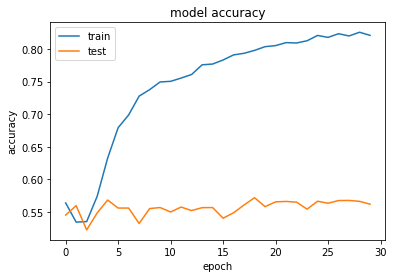

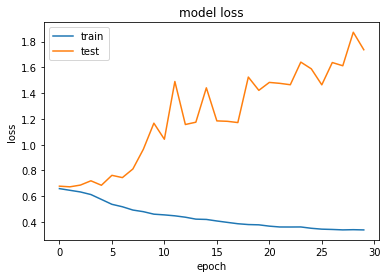

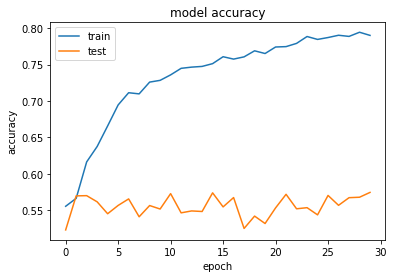

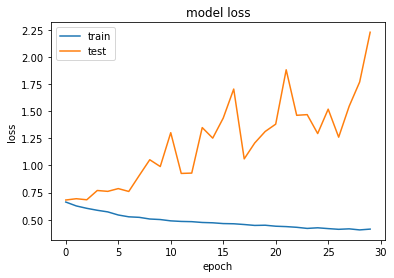

In [15]:
plot_history(history1)
plot_history(history2)

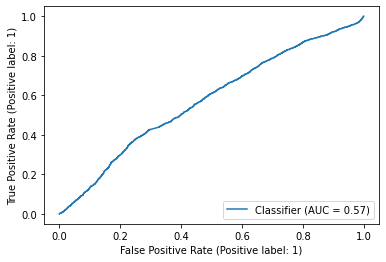

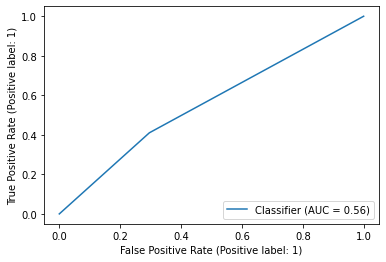

In [16]:
y_hat = model1.predict(X_test_scaled)

RocCurveDisplay.from_predictions(y_pred=y_hat, y_true=y_test, pos_label=1)

y_hat = model2.predict(X_test_scaled)
y_hat = np.argmax(y_hat, axis=1)

RocCurveDisplay.from_predictions(y_pred=y_hat, y_true=y_test, pos_label=1)